In [157]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from tqdm import tqdm
import pandas as pd
import numpy as np
import zipfile
import ollama
import os
plt.rcParams['figure.dpi'] = 300

In [33]:
# Define some paths
root = "."

# Set path to descriptions
pathogen_code = "mtuberculosis"
PATH_TO_DESCRIPTIONS = os.path.join(root, "..", "output", pathogen_code, "descriptions")

# Get assay data
ASSAYS = pd.read_csv(os.path.join(root, "..", "output", pathogen_code, "assays.csv"), low_memory=False)[:4500]

In [114]:
TEXT_LEN, EMBEDDINGS, CPDS = {}, {}, {}
ASSAY_ORGANISM, TARGET_ORGANISM = {}, {}
MEDIA = {}

# For each assay
for data in tqdm(ASSAYS.iterrows()):
    
    # Get data
    data = data[1]
    assay_id = data['assay_id']
    act_type = data['activity_type']
    unit = data['unit']

    # Change unit format
    if type(unit) != str:
        unit = 'nan'
    else:
        unit = unit.replace('/', 'FwdS').replace(" ", "__")

    # Get input and output
    filename = "_".join([assay_id, act_type, unit])
    CPDS[filename] = data['cpds']
    ASSAY_ORGANISM[filename] = data['assay_organism']
    TARGET_ORGANISM[filename] = data['target_organism']
    with zipfile.ZipFile(os.path.join(PATH_TO_DESCRIPTIONS, filename + ".zip"), "r") as zip_file:
        TEXT_LEN[filename] = [0, 0]
        for file in zip_file.namelist():
            with zip_file.open(file) as f:
                content = f.read().decode('utf-8')
                # Input
                if 'input' in file:
                    TEXT_LEN[filename][0] = len(content)
                    if "variant bovis BCG" in content:
                        MEDIA[filename] = "variant bovis BCG"
                    else:
                        MEDIA[filename] = "Other"
                # Output
                else:
                    TEXT_LEN[filename][1] = len(content)
                    emb = np.array(ollama.embeddings(model='nomic-embed-text', prompt=content).embedding)
                    if len(emb) != 768:
                        print(f"Embedding length for file {filename} is {len(emb)}")
                    else:
                        EMBEDDINGS[filename] = emb

534it [00:07, 69.52it/s]

Embedding length for file CHEMBL4003019_MIC_umol.L-1 is 0


2004it [00:26, 75.05it/s] 

Embedding length for file CHEMBL4775335_MIC>99_umol.L-1 is 0


4500it [00:59, 75.90it/s] 


In [109]:
Counter(TARGET_ORGANISM.values())

Counter({'Mycobacterium tuberculosis': 3995,
         nan: 306,
         'Mycobacterium tuberculosis (strain ATCC 25618 / H37Rv)': 83,
         'Mycobacterium tuberculosis variant bovis': 61,
         'Mycobacterium tuberculosis variant bovis BCG': 36,
         'Mycobacterium tuberculosis H37Rv': 12,
         'Mycobacterium tuberculosis (strain CDC 1551 / Oshkosh)': 6,
         'Mycobacterium tuberculosis variant microti': 1})

In [110]:
Counter(ASSAYS['activity_type'].values)

Counter({'MIC': 2060,
         'IC50': 404,
         'INHIBITION': 371,
         'MIC90': 322,
         'ACTIVITY': 207,
         'GI': 179,
         'MIC99': 130,
         'MIC>99': 83,
         'MIC50': 82,
         'KI': 78,
         'IC90': 66,
         'RATIO': 61,
         'MIC>90': 41,
         'MIC=>90': 38,
         'KD': 34,
         'FC': 34,
         'MIC=>80': 27,
         'MBC': 27,
         'EC50': 14,
         '-LOGMIC': 14,
         'MIC=<90': 13,
         'MIC95': 13,
         'DELTATM': 13,
         'MIC80': 11,
         'GROWTHINDEX': 11,
         'PERCENTEFFECT': 9,
         'AC50': 8,
         'LOG(ACTIVITY)': 8,
         'LOG10CFU': 7,
         'IZ': 7,
         'KCATKM': 6,
         'LOG1MMIC': 6,
         'EC90': 6,
         'FIC': 6,
         'RATIOIC50': 5,
         'MBC90': 5,
         'GI50': 5,
         'KCAT': 5,
         'LOG(1MIC)': 4,
         'MIC100': 4,
         'KM': 4,
         'CONCENTRATION': 4,
         'K': 3,
         'EC99': 3,
         'KCA

In [162]:
# Get data matrix and labels
print("Getting data matrix...")
assays = sorted(EMBEDDINGS)
X = np.array([EMBEDDINGS[assay] for assay in assays])
sizes = np.array([CPDS[i] for i in assays])


# colors = np.array(["#AA96FA" if TARGET_ORGANISM[i] == "Mycobacterium tuberculosis variant bovis BCG" else "#D2D2D2" for i in assays])
# colors = np.array(["#AA96FA" if i.split("_")[1] == 'ACTIVITY' else "#D2D2D2" for i in assays])
# colors = np.array(["#AA96FA" if MEDIA[i] == "variant bovis BCG" else "#D2D2D2" for i in assays])
# colors = np.array(["#AA96FA" if i.split("_")[2] == 'nan' else "#D2D2D2" for i in assays])

# cluster = AgglomerativeClustering(n_clusters=10, distance_threshold=0.2, metric='cosine', linkage='average').fit(X)
cluster = KMeans(n_clusters=20).fit(X)
colors = cluster.labels_


ind = np.argsort(colors)[::-1]
print(Counter(colors))

# Compute tSNE
print("Computing tSNE...")
tsne = TSNE(n_components=2, random_state=42, metric='cosine', n_jobs=8).fit_transform(X)

Getting data matrix...
Counter({6: 1412, 11: 446, 13: 315, 5: 284, 16: 275, 9: 229, 3: 214, 18: 183, 12: 171, 14: 155, 0: 139, 1: 128, 15: 120, 2: 111, 10: 83, 4: 74, 17: 69, 19: 45, 8: 36, 7: 9})
Computing tSNE...


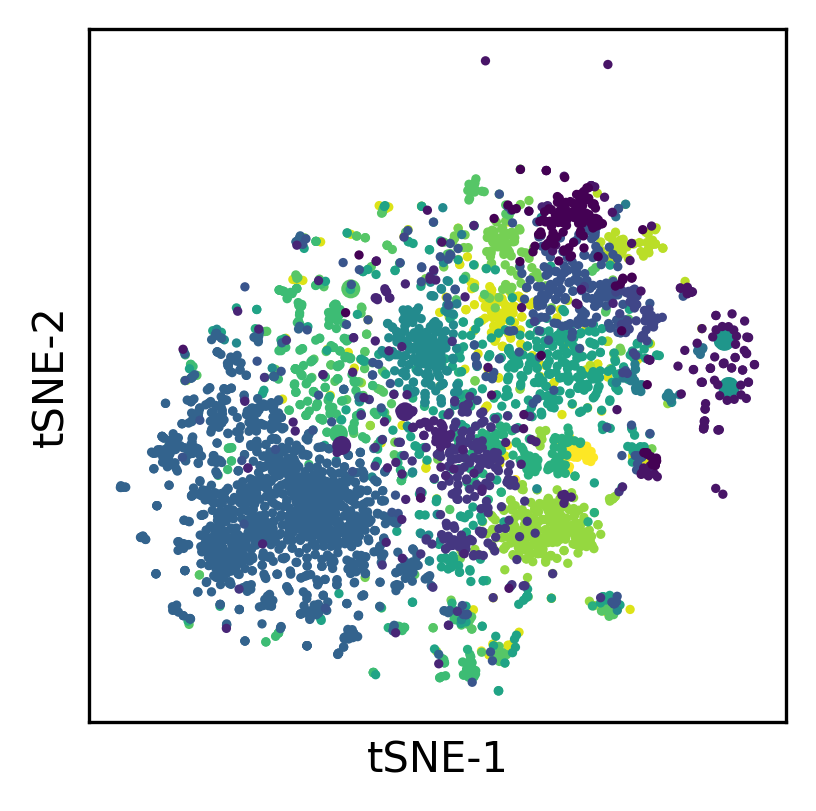

In [168]:
MIN, MAX = 5, 25
sizes_scaled = MIN + (MAX-MIN) * (sizes - sizes.min()) / (sizes.max() - sizes.min())

plt.figure(figsize=(3,3))
plt.xticks([])
plt.yticks([])
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.scatter(tsne[ind][:,0], tsne[ind][:,1], s=sizes_scaled[ind], marker='o', linewidth=0, alpha=1, zorder=2, c=colors[ind])
plt.grid(linestyle='--', alpha=1)
plt.show()

In [91]:
[[i, j] for i,j in zip(tsne, assays) if i[0] > 30 and i[1] < -30]

[[array([ 38.25662 , -36.811596], dtype=float32),
  'CHEMBL3266383_MIC_umol.L-1'],
 [array([ 39.89643 , -40.230747], dtype=float32),
  'CHEMBL3266384_MIC_umol.L-1'],
 [array([ 39.050316, -37.54244 ], dtype=float32),
  'CHEMBL3266385_MIC_umol.L-1'],
 [array([ 36.30999 , -38.809776], dtype=float32),
  'CHEMBL3266386_MIC_umol.L-1'],
 [array([ 39.018036, -39.02708 ], dtype=float32),
  'CHEMBL3266387_MIC_umol.L-1'],
 [array([ 41.63548, -36.73069], dtype=float32), 'CHEMBL3266390_MIC_umol.L-1'],
 [array([ 36.147545, -38.775723], dtype=float32),
  'CHEMBL3266391_MIC_umol.L-1'],
 [array([ 39.18647, -40.2221 ], dtype=float32), 'CHEMBL3266392_MIC_umol.L-1'],
 [array([ 37.799873, -37.039726], dtype=float32),
  'CHEMBL3266393_MIC_umol.L-1'],
 [array([ 38.290398, -36.96568 ], dtype=float32),
  'CHEMBL3266394_MIC_umol.L-1'],
 [array([ 38.45891 , -36.820473], dtype=float32),
  'CHEMBL3266395_MIC_umol.L-1'],
 [array([ 40.691845, -39.985973], dtype=float32),
  'CHEMBL3271116_MBC_umol.L-1'],
 [array([ 40